# Twitter Sentiment Analysis
En este notebook vas a ver un ejemplo de los procesos necesarios para realizar un análisis de sentimientos sobre Tweets. Para ello tendremos que seguir los siguientes pasos:
1. Conseguir un Corpus: no es más que una base de datos de texto etiquetado
2. Limpiar los datos
3. Entrenar un modelo con el corpus
4. Cargar un lexicon sentimental
5. Hacer un modelo no_supervisado basado en el lexicon
6. Compararlo con el modelo anteriormente entrenado

**Estos programas son muy útiles en campañas de marketing, para monitorizar el lanzamiento de un nuevo producto, realizar seguimiento en Twitter de eventos, o simplemente tener monitorizadas ciertas cuentas o hashtags para tener un programa de análisis real time.**

## 1. Corpus
Para conseguir el corpus tendremos que registrarnos en la [página del TASS](http://tass.sepln.org/tass_data/download.php), que se trata de una asociación de análisis semántico que encargada de recopilar texto y mantenerlo etiquetado. 

Para datasets en ingles lo tenemos más fácil ya que con librerías como [TextBlob](https://textblob.readthedocs.io/en/dev/) podemos predecir directamente la polaridad del Tweet, con modelos ya preentrenados. En el caso del castellano necesitamos acudir a un corpus etiquetado para entrenar nuestro modelo.

Registrate en el TASS y accede a sus corpus a través de un link que te llegará al correo tras el registro.

![imagen](img/tass_register.png)


Una vez estes registrado, descárgate el corpus de tweets en español de entrenamiento. En este punto lo ideal es coger un corpus que se adapte lo máximo posible a los tipos de tweets que intentamos predecir, es decir, si queremos predecir tweets sobre política, procurar elegir un corpus que tenga vocabulario de política.

En este notebook se va a elegir un corpus genérico con no demasiados registros para aligerar la limpieza y entrenamiento de los modelos.

![imagen](img/download_train_spanish.png)

### Importamos librerias

In [278]:
import pandas as pd
import re
import seaborn as sns
import xml.etree.ElementTree as ET

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

### Leemos el dataset

In [279]:
tree = ET.parse('data/general-train-tagged.xml')
root = tree.getroot()

In [280]:
raw_dict = {
    'User': [],
    'Content': [],
    'Date': [],
    'Lang': [],
    'Polarity': [],
    'Type': []
}

for i in root.iter('tweet'):
    user = i.find('user').text
    content = i.find('content').text
    date = i.find('date').text
    lang = i.find('lang').text
    polarity = i.find('sentiments').find('polarity').find('value').text
    tweet_type = i.find('sentiments').find('polarity').find('type').text
    
    raw_dict['User'].append(user)
    raw_dict['Content'].append(content)
    raw_dict['Date'].append(date)
    raw_dict['Lang'].append(lang)
    raw_dict['Polarity'].append(polarity)
    raw_dict['Type'].append(tweet_type)
    
df = pd.DataFrame(raw_dict)
print(df.shape)

df.head()

(7219, 6)


User                                            Content  \
0      ccifuentes        Salgo de #VeoTV , que día más largoooooo...   
1  CarmendelRiego  @PauladeLasHeras No te libraras de ayudar me/n...   
2  CarmendelRiego                          @marodriguezb Gracias MAR   
3    mgilguerrero  Off pensando en el regalito Sinde, la que se v...   
4        paurubio  Conozco a alguien q es adicto al drama! Ja ja ...   

                  Date Lang Polarity          Type  
0  2011-12-02T00:47:55   es     NONE     AGREEMENT  
1  2011-12-02T00:49:40   es      NEU  DISAGREEMENT  
2  2011-12-02T00:57:40   es        P     AGREEMENT  
3  2011-12-02T02:33:37   es       N+     AGREEMENT  
4  2011-12-02T02:59:03   es       P+     AGREEMENT

### Columna de polaridad

In [281]:
# Vemos los valores unicos de la columna de polaridad
df.Polarity.unique()

array(['NONE', 'NEU', 'P', 'N+', 'P+', 'N'], dtype=object)

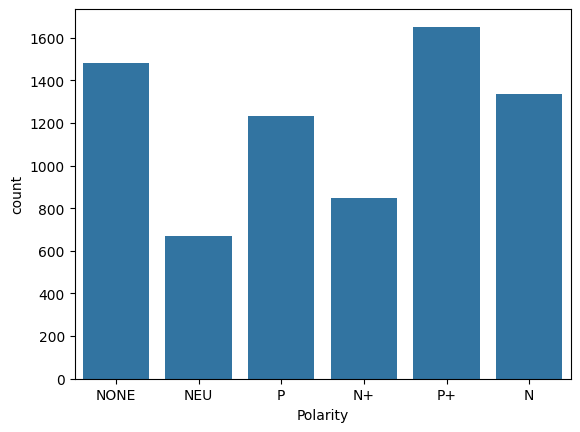

In [282]:
sns.countplot(x ='Polarity', data = df);

#### Columna de tipo

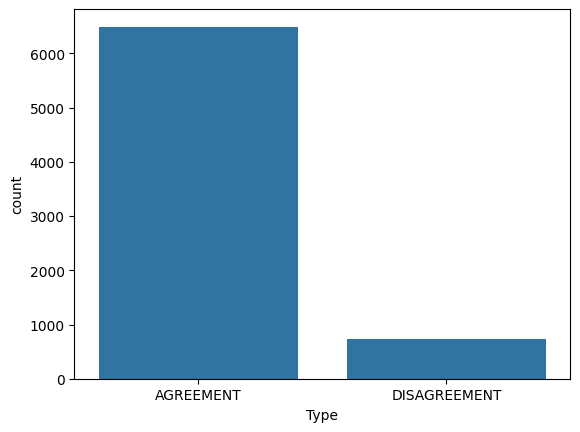

In [283]:
sns.countplot(x ='Type', data = df);

## 2. Limpieza de datos
#### Polaridad
Vamos a clasificar los Tweets como buenos o malos, por lo que haremos la siguiente agrupación de la polaridad

In [284]:
def polaridad_fun(x):
    if x in ('P', 'P+'):
        return 0
    elif x in ('N', 'N+'):
        return 1

In [285]:
# Nos cargamos los NONE y los neutros
df = df[~df['Polarity'].isin(['NONE','NEU'])]
df['Polarity'].unique()

array(['P', 'N+', 'P+', 'N'], dtype=object)

In [286]:
# Pasamos la columna a 1s y 0s. Y el tipo
df['Polarity'] = df['Polarity'].apply(polaridad_fun)
df['Polarity'].unique()

array([0, 1], dtype=int64)

#### Idioma
Nos quedamos con los tweets en español. Si no tuviésemos esa columna podríamos acudir a librerías como `langid` o `langdetect`.

In [287]:
# Filtramos los tweets en español
df = df[df['Lang'] == 'es']

In [288]:
# Vemos con cuantos registros nos hemos quedado despues del filtrado
df.shape

(5066, 6)

#### Duplicados

In [289]:
# Eliminamos los duplicados
df.drop_duplicates(subset = 'Content', inplace = True)
df.shape

(5052, 6)

#### Signos de puntuación
Eliminamos signos de puntuación: puntos, comas, interrogaciones, paréntesis

In [290]:
df['Content'].head()

2                            @marodriguezb Gracias MAR
3    Off pensando en el regalito Sinde, la que se v...
4    Conozco a alguien q es adicto al drama! Ja ja ...
6    Toca @crackoviadeTV3 . Grabación dl especial N...
8    Buen día todos! Lo primero mandar un abrazo gr...
Name: Content, dtype: object

In [291]:
import re

signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")

def signs_tweets(tweet):
    return signos.sub('', tweet.lower())

df['Content_bck'] = df['Content']
df['Content'] = df['Content'].apply(signs_tweets)
df['Content'].head()

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Jonatan\AppData\Local\Temp\ipykernel_19688\1666706401.py:3: SyntaxWarning: invalid escape sequence '\.'
  signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")


2                            @marodriguezb gracias mar
3    off pensando en el regalito sinde la que se va...
4    conozco a alguien q es adicto al drama ja ja j...
6    toca @crackoviadetv  grabación dl especial nav...
8    buen día todos lo primero mandar un abrazo gra...
Name: Content, dtype: object

In [292]:
# otra forma
import string
"hola, adios...!".translate(str.maketrans('', '', string.punctuation))

'hola adios'

In [293]:
df.head()

User                                            Content  \
2  CarmendelRiego                          @marodriguezb gracias mar   
3    mgilguerrero  off pensando en el regalito sinde la que se va...   
4        paurubio  conozco a alguien q es adicto al drama ja ja j...   
6    Carlos_Latre  toca @crackoviadetv  grabación dl especial nav...   
8   nacho_uriarte  buen día todos lo primero mandar un abrazo gra...   

                  Date Lang  Polarity       Type  \
2  2011-12-02T00:57:40   es         0  AGREEMENT   
3  2011-12-02T02:33:37   es         1  AGREEMENT   
4  2011-12-02T02:59:03   es         0  AGREEMENT   
6  2011-12-02T07:00:50   es         0  AGREEMENT   
8  2011-12-02T07:45:05   es         0  AGREEMENT   

                                         Content_bck  
2                          @marodriguezb Gracias MAR  
3  Off pensando en el regalito Sinde, la que se v...  
4  Conozco a alguien q es adicto al drama! Ja ja ...  
6  Toca @crackoviadeTV3 . Grabación dl especial N...  
8  Buen día todos! Lo primero mandar un abrazo gr...

#### Eliminamos links

In [294]:
# repasar métodos str
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

df['Content'] = df['Content'].apply(remove_links)

#### Otros
Podríamos hacer un preprocesado mucho más fino:
1. Hashtags
2. Menciones
3. Abreviaturas
4. Faltas de ortografía
5. Risas

## 3. Modelo
Para montar el modelo tendremos que seguir los siguientes pasos
1. Eliminamos las stopwords
2. Aplicamos un stemmer, SnowBall por ejemplo

#### Stopwords

In [295]:
# Solo una vez
#!pip install NLTK
#import nltk
#nltk.download('stopwords')

In [296]:

from nltk.corpus import stopwords

spanish_stopwords = stopwords.words('spanish')

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

df['Content'] = df['Content'].apply(remove_stopwords)
df.head()

User                                            Content  \
2  CarmendelRiego                          @marodriguezb gracias mar   
3    mgilguerrero  off pensando regalito sinde va sgae van corrup...   
4        paurubio    conozco alguien q adicto drama ja ja ja suena d   
6    Carlos_Latre  toca @crackoviadetv grabación dl especial navi...   
8   nacho_uriarte  buen día primero mandar abrazo grande miguel f...   

                  Date Lang  Polarity       Type  \
2  2011-12-02T00:57:40   es         0  AGREEMENT   
3  2011-12-02T02:33:37   es         1  AGREEMENT   
4  2011-12-02T02:59:03   es         0  AGREEMENT   
6  2011-12-02T07:00:50   es         0  AGREEMENT   
8  2011-12-02T07:45:05   es         0  AGREEMENT   

                                         Content_bck  
2                          @marodriguezb Gracias MAR  
3  Off pensando en el regalito Sinde, la que se v...  
4  Conozco a alguien q es adicto al drama! Ja ja ...  
6  Toca @crackoviadeTV3 . Grabación dl especial N...  
8  Buen día todos! Lo primero mandar un abrazo gr...

#### Stemmer

In [297]:
df_before_stemmer = df.copy()

In [298]:
from nltk.stem.snowball import SnowballStemmer

def spanish_stemmer(x):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in x.split()])

df['Content_stem'] = df['Content'].apply(spanish_stemmer)

#### Seleccionamos columnas
Nos quedamos con las columnas que nos interesan para el modelo

In [299]:
df_old = df.copy()

In [300]:
df = df[['Content_stem', 'Polarity']]

#### Vectorizamos el dataset

In [301]:
vectorizer = CountVectorizer()

In [302]:
vectorizer.fit(df["Content_stem"])

CountVectorizer()

In [303]:
pd.DataFrame(vectorizer.vocabulary_, index=[1])

marodriguezb  graci   mar   off  pens  regalit  sind     va   sga    van  \
1          6317   4572  6250  7147  7598     8510  9194  10079  9119  10122   

   ...  buzon  ubic  rick  santorum  jiraf  zoomadr  pablo_roy  huid  \
1  ...   1424  9983  8693      8950   5488    10529       7316  4921   

   corremarianocorr  corremarianoquechov  
1              2372                 2373  

[1 rows x 10542 columns]

In [304]:
vectorizer.transform(df["Content_stem"]).toarray().shape

(5052, 10542)

#### Montamos Pipeline

#### Entrenamos

In [305]:
from sklearn.model_selection import train_test_split

In [306]:
X_train,X_test,y_train,y_test = train_test_split(df['Content_stem'],df['Polarity'], test_size = 0.2)

In [307]:
#LinearSVC() es el clasificador
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('cls', XGBClassifier()),
])

# Aqui definimos el espacio de parámetros a explorar
parameters = {
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigramas or bigramas
   'cls__n_estimators': (100, 200, 1000, 2000)
}


grid_search = GridSearchCV(pipeline,
                           parameters,
                           cv=5,
                           n_jobs=-1 ,
                           scoring='accuracy')

In [308]:
grid_search.fit(X_train,
                y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('cls',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=Non...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'cls__n_estimators': (100, 200, 1000, 2000),
                         'vect__ngram_range': ((1, 1), (1, 2))},
             scoring='accuracy')

In [309]:
print("Best params:", grid_search.best_params_)
print("Best acc:", grid_search.best_score_)
print("Best model:", grid_search.best_estimator_)

Best params: {'cls__n_estimators': 200, 'vect__ngram_range': (1, 2)}
Best acc: 0.7604587621926593
Best model: Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('cls',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                      

In [310]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [311]:
predictions = grid_search.best_estimator_.predict(X_test)

In [312]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80       559
           1       0.78      0.66      0.71       452

    accuracy                           0.76      1011
   macro avg       0.77      0.75      0.76      1011
weighted avg       0.77      0.76      0.76      1011



### AÑADIMOS OTRAS FEATURES

In [313]:
sonrisas = re.compile("([:X;8]-[\)DP])")
def have_risas_emojis(row):
    if len(sonrisas.findall(row)):
        return 1
    return 0

<>:1: SyntaxWarning: invalid escape sequence '\)'
<>:1: SyntaxWarning: invalid escape sequence '\)'
C:\Users\Jonatan\AppData\Local\Temp\ipykernel_19688\2320608685.py:1: SyntaxWarning: invalid escape sequence '\)'
  sonrisas = re.compile("([:X;8]-[\)DP])")


In [314]:
lagrimas = re.compile("([:;8]-[\(O]+)")
def have_lagrimas_emojis(row):
    if len(lagrimas.findall(row)):
        return 1
    return 0

<>:1: SyntaxWarning: invalid escape sequence '\('
<>:1: SyntaxWarning: invalid escape sequence '\('
C:\Users\Jonatan\AppData\Local\Temp\ipykernel_19688\2804320210.py:1: SyntaxWarning: invalid escape sequence '\('
  lagrimas = re.compile("([:;8]-[\(O]+)")


In [315]:
def word_count(row):
    return len(row)

In [316]:
df["tiene_sonrisas"] = df_old["Content_bck"].apply(have_risas_emojis)

In [317]:
df["tiene_lagrimas"] = df_old["Content_bck"].apply(have_lagrimas_emojis)

In [318]:
df["cuenta_tokens"] = df["Content_stem"].apply(word_count)

In [319]:

preprocessing = ColumnTransformer([
    ("vect",CountVectorizer(),"Content_stem")],
    remainder = "passthrough")
new_pipeline = Pipeline([
    ("preprocesado",preprocessing),
    ("cls",XGBClassifier())
])

In [335]:

new_parameters = {
    'preprocesado__vect__ngram_range': ((1, 1), (1, 2)),  # unigramas or bigramas
    'cls__n_estimators': (100, 200, 1000, 2000)
}


grid_search_new_feats = GridSearchCV(new_pipeline,
                           new_parameters,
                           cv=5,
                           n_jobs=-1 ,
                           scoring='accuracy')

X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=["Polarity"]),df['Polarity'], test_size = 0.2)

In [336]:
df

Content_stem  Polarity  \
2                               @marodriguezb graci mar         0   
3     off pens regalit sind va sga van corrupt inten...         1   
4             conozc algui q adict dram ja ja ja suen d         0   
6     toc @crackoviadetv grabacion dl especial navid...         0   
8     buen dia primer mand abraz grand miguel famili...         0   
...                                                 ...       ...   
7214  indign si nadi rep ello hoy aqui graci rt @lol...         1   
7215                          pobr discrimin muj {link}         1   
7216             cre banc product mujer canc mam {link}         0   
7217              sorprendent huid hoy sen rajoy {link}         1   
7218  #corremarianocorr bien version galleg #correma...         0   

      tiene_sonrisas  tiene_lagrimas  cuenta_tokens Polarity_  
2                  0               0             23       N/S  
3                  0               0             69       N/S  
4                  0               0             41       N/S  
6                  0               0             59         P  
8                  0               0             91         P  
...              ...             ...            ...       ...  
7214               0               0             72       NaN  
7215               0               0             25       NaN  
7216               0               0             38       NaN  
7217               0               0             37       NaN  
7218               0               0             69       NaN  

[5052 rows x 6 columns]

In [322]:
%%time
grid_search_new_feats.fit(X_train,
                y_train)

CPU times: total: 1min
Wall time: 1min 52s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('vect',
                                                                         CountVectorizer(),
                                                                         'Content_stem')])),
                                       ('cls',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'cls__n_estimators': (100, 200, 1000, 2000),
                         'preprocesado__vect__ngram_range': ((1, 1), (1, 2))},
             scoring='accuracy')

In [323]:
print("Best params:", grid_search_new_feats.best_params_)
print("Best acc:", grid_search_new_feats.best_score_)
print("Best model:", grid_search_new_feats.best_estimator_)

Best params: {'cls__n_estimators': 200, 'preprocesado__vect__ngram_range': (1, 2)}
Best acc: 0.7577317064215692
Best model: Pipeline(steps=[('preprocesado',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vect',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'Content_stem')])),
                ('cls',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval...
                               feature_types=None, gamma=None, grow_policy=None,
                               import

In [324]:
predictions = grid_search_new_feats.best_estimator_.predict(X_test)

In [325]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       574
           1       0.71      0.69      0.70       437

    accuracy                           0.74      1011
   macro avg       0.74      0.74      0.74      1011
weighted avg       0.74      0.74      0.74      1011



### SUPONGAMOS QUE NO TENEMOS LABEL, "MODELO" NO SUPERVISADO

Cargamos un lexicon "sentimental"

In [326]:
df_lexicon = pd.read_csv("./data/spanish_sentiments.csv")

In [327]:
df_lexicon

lemma  Polarity
0              a_buena_fé    0.5000
1               a_capella   -0.2500
2      a_cara_descubierta    0.2500
3                 a_gusto    0.7500
4          a_la_defensiva   -0.3750
...                   ...       ...
11339             ósmosis   -0.2500
11340               ótico   -0.2500
11341       óxido_nítrico   -0.3750
11342               único    0.3330
11343                útil    0.4065

[11344 rows x 2 columns]

Ojo: Está indexado por Lemma (sin cojugar, en singular, en masculino)

¿Cómo nos afectará?

Nos contruimos nuestro modelo basado en las puntuaciones del lexicon

In [328]:
import numpy as np
def score_lexicon(text,threshold = 0.0):
    score = 0
    cuenta = 0
    for word in text.split():
        #print(word)
        try:
            score += df_lexicon[df_lexicon.lemma == word.lower()].Polarity.values[0]
            cuenta += 1
        except:
            #print("No esta en el lexicon")
            continue
    score = score/cuenta if cuenta > 0 else -99999
    return "P" if score > threshold else "N" if score > -99999 else "N/S"
    

Pero no lo podemos aplicar al contenido procesado porque le hemos aplicado el stemming

In [329]:
%%time
df["Polarity_"] = df.iloc[0:100]["Content_stem"].apply(score_lexicon)

CPU times: total: 219 ms
Wall time: 905 ms


In [330]:
df.Polarity_.value_counts()

Polarity_
N/S    74
P      26
Name: count, dtype: int64

Lo aplicamos al contenido original

In [331]:
%%time
df_old["Polarity_"] = df_old.iloc[0:100]["Content_bck"].apply(score_lexicon)

CPU times: total: 203 ms
Wall time: 952 ms


In [332]:
df_old.iloc[0:100]["Polarity_"].value_counts()

Polarity_
P      47
N/S    34
N      19
Name: count, dtype: int64

Sale algo mejor, pero todavía hay muchos N/S, ¿por qué? Porque espera lemmas. Tenemos que lemmatizar

Para lemmatizar aprovecharemos las capacidades de una biblioteca muy potente para NLP, spacy, que además tiene modelos pre-entrenados en español

In [342]:
# Solo la primera vez
#!pip install spacy
#!python -m spacy download "es_core_news_lg"

     ---------------------------------------- 0.0/568.0 MB ? eta -:--:--
     -------------------------------------- 0.0/568.0 MB 330.3 kB/s eta 0:28:40
     ---------------------------------------- 0.1/568.0 MB 1.6 MB/s eta 0:06:01
     ---------------------------------------- 0.6/568.0 MB 5.5 MB/s eta 0:01:43
     --------------------------------------- 1.4/568.0 MB 10.7 MB/s eta 0:00:53
     ---------------------------------------- 1.7/568.0 MB 9.3 MB/s eta 0:01:02
     --------------------------------------- 2.6/568.0 MB 12.9 MB/s eta 0:00:44
     --------------------------------------- 3.8/568.0 MB 15.1 MB/s eta 0:00:38
     --------------------------------------- 5.2/568.0 MB 17.6 MB/s eta 0:00:32
     --------------------------------------- 6.6/568.0 MB 19.1 MB/s eta 0:00:30
      -------------------------------------- 8.4/568.0 MB 22.4 MB/s eta 0:00:25
      -------------------------------------- 9.5/568.0 MB 23.3 MB/s eta 0:00:24
      ------------------------------------- 10.


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [343]:
import spacy

In [344]:
nlp = spacy.load("es_core_news_lg") # Cargamos el modelo en español

In [345]:
doc = nlp("Esto es la prueba 23") #Le metemos un texto y además de tokenizarlo, nos va a dar bastantes más features

In [346]:
for token in doc:
    print(token.text, "-> Lema: ", token.lemma_, "-> PoS Tag", token.pos_, "-> Puede ser un numero?", token.like_num)


Esto -> Lema:  este -> PoS Tag PRON -> Puede ser un numero? False
es -> Lema:  ser -> PoS Tag AUX -> Puede ser un numero? False
la -> Lema:  el -> PoS Tag DET -> Puede ser un numero? False
prueba -> Lema:  prueba -> PoS Tag NOUN -> Puede ser un numero? False
23 -> Lema:  23 -> PoS Tag NUM -> Puede ser un numero? True


Utilizemos su lemmatizador para poder aprovechar el lexicon

In [347]:
def new_scorer(doc):
    parsed_doc = nlp(doc)
    new_doc = " ".join([token.lemma_ for token in parsed_doc])
    return score_lexicon(new_doc)
    

In [348]:
df_before_stemmer["New_Pol"] = df_before_stemmer["Content"].apply(new_scorer)

In [349]:
df_before_stemmer

User                                            Content  \
2     CarmendelRiego                          @marodriguezb gracias mar   
3       mgilguerrero  off pensando regalito sinde va sgae van corrup...   
4           paurubio    conozco alguien q adicto drama ja ja ja suena d   
6       Carlos_Latre  toca @crackoviadetv grabación dl especial navi...   
8      nacho_uriarte  buen día primero mandar abrazo grande miguel f...   
...              ...                                                ...   
7214    mariviromero  indignante si nadie repara ello hoy aqui graci...   
7215    mariviromero                    pobres discriminar mujer {link}   
7216    mariviromero   crean banco productos mujeres cáncer mama {link}   
7217      Tonicanto1         sorprendente huída hoy senado rajoy {link}   
7218    RodolfoIrago  #corremarianocorre bien versión gallega #corre...   

                     Date Lang  Polarity       Type  \
2     2011-12-02T00:57:40   es         0  AGREEMENT   
3     2011-12-02T02:33:37   es         1  AGREEMENT   
4     2011-12-02T02:59:03   es         0  AGREEMENT   
6     2011-12-02T07:00:50   es         0  AGREEMENT   
8     2011-12-02T07:45:05   es         0  AGREEMENT   
...                   ...  ...       ...        ...   
7214  2012-04-10T22:19:42   es         1  AGREEMENT   
7215  2012-04-10T22:39:22   es         1  AGREEMENT   
7216  2012-04-10T22:41:30   es         0  AGREEMENT   
7217  2012-04-10T23:16:49   es         1  AGREEMENT   
7218  2012-04-10T23:40:36   es         0  AGREEMENT   

                                            Content_bck New_Pol  
2                             @marodriguezb Gracias MAR     N/S  
3     Off pensando en el regalito Sinde, la que se v...       N  
4     Conozco a alguien q es adicto al drama! Ja ja ...       P  
6     Toca @crackoviadeTV3 . Grabación dl especial N...       P  
8     Buen día todos! Lo primero mandar un abrazo gr...       P  
...                                                 ...     ...  
7214  Muy indignante si ...nadie repara en ello hoy ...       N  
7215  Más pobres por discriminar a la mujer http://t...     N/S  
7216  Crean un banco de productos para mujeres con c...     N/S  
7217  Sobre la sorprendente huída hoy en el Senado d...     N/S  
7218  #CorreMarianoCorre está muy bien pero la versi...       P  

[5052 rows x 8 columns]

In [350]:
df_before_stemmer["New_Pol"].value_counts()

New_Pol
P      2678
N/S    1587
N       787
Name: count, dtype: int64

In [351]:
df_before_stemmer.New_Pol.value_counts(True)

New_Pol
P      0.530087
N/S    0.314133
N      0.155780
Name: proportion, dtype: float64

In [352]:
df_before_stemmer["Aciertos"] = df_before_stemmer[["New_Pol","Polarity"]].apply(lambda row: 1 if (row[0] == "P" and row[1] == 0) or (row[0] == "N" and row[1] == 1) else 0, axis = 1)

C:\Users\Jonatan\AppData\Local\Temp\ipykernel_19688\994110956.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_before_stemmer["Aciertos"] = df_before_stemmer[["New_Pol","Polarity"]].apply(lambda row: 1 if (row[0] == "P" and row[1] == 0) or (row[0] == "N" and row[1] == 1) else 0, axis = 1)


In [353]:
df_before_stemmer

User                                            Content  \
2     CarmendelRiego                          @marodriguezb gracias mar   
3       mgilguerrero  off pensando regalito sinde va sgae van corrup...   
4           paurubio    conozco alguien q adicto drama ja ja ja suena d   
6       Carlos_Latre  toca @crackoviadetv grabación dl especial navi...   
8      nacho_uriarte  buen día primero mandar abrazo grande miguel f...   
...              ...                                                ...   
7214    mariviromero  indignante si nadie repara ello hoy aqui graci...   
7215    mariviromero                    pobres discriminar mujer {link}   
7216    mariviromero   crean banco productos mujeres cáncer mama {link}   
7217      Tonicanto1         sorprendente huída hoy senado rajoy {link}   
7218    RodolfoIrago  #corremarianocorre bien versión gallega #corre...   

                     Date Lang  Polarity       Type  \
2     2011-12-02T00:57:40   es         0  AGREEMENT   
3     2011-12-02T02:33:37   es         1  AGREEMENT   
4     2011-12-02T02:59:03   es         0  AGREEMENT   
6     2011-12-02T07:00:50   es         0  AGREEMENT   
8     2011-12-02T07:45:05   es         0  AGREEMENT   
...                   ...  ...       ...        ...   
7214  2012-04-10T22:19:42   es         1  AGREEMENT   
7215  2012-04-10T22:39:22   es         1  AGREEMENT   
7216  2012-04-10T22:41:30   es         0  AGREEMENT   
7217  2012-04-10T23:16:49   es         1  AGREEMENT   
7218  2012-04-10T23:40:36   es         0  AGREEMENT   

                                            Content_bck New_Pol  Aciertos  
2                             @marodriguezb Gracias MAR     N/S         0  
3     Off pensando en el regalito Sinde, la que se v...       N         1  
4     Conozco a alguien q es adicto al drama! Ja ja ...       P         1  
6     Toca @crackoviadeTV3 . Grabación dl especial N...       P         1  
8     Buen día todos! Lo primero mandar un abrazo gr...       P         1  
...                                                 ...     ...       ...  
7214  Muy indignante si ...nadie repara en ello hoy ...       N         1  
7215  Más pobres por discriminar a la mujer http://t...     N/S         0  
7216  Crean un banco de productos para mujeres con c...     N/S         0  
7217  Sobre la sorprendente huída hoy en el Senado d...     N/S         0  
7218  #CorreMarianoCorre está muy bien pero la versi...       P         1  

[5052 rows x 9 columns]

In [354]:
df_before_stemmer.Aciertos.value_counts(True)

Aciertos
0    0.521774
1    0.478226
Name: proportion, dtype: float64

In [355]:
df_before_stemmer[df_before_stemmer.New_Pol != "N/S"].Aciertos.value_counts(True)

Aciertos
1    0.697258
0    0.302742
Name: proportion, dtype: float64